In [22]:
# Basic exploratory data analysis of the Ames House Price Dataset
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression

# Read in the data
house = pd.read_csv('./train_cleaned.csv')

In [23]:
# Out of interest - how big is the test set?
house_test = pd.read_csv('../rawData/test.csv')
house_test.shape
#1460+1459=2919

(1459, 80)

In [24]:
# follow advice from http://jse.amstat.org/v19n3/decock.pdf to remove outliers
house = house[house['GrLivArea']<=4000]
nrows, ncols = house.shape

# Define mean sale price
mu_abs = house['SalePrice'].mean()

In [25]:
# This is the cleaned dataset so
house.columns[house.isna().any()]

Index([], dtype='object')

In [26]:
# Does price vary over time?
house['SaleDate'] = house[['YrSold', 'MoSold']].apply(lambda x: datetime.date(x[0], x[1], 1), axis = 1)
df = house.groupby('SaleDate')['SalePrice'].agg(['mean', 'count'])
lin = LinearRegression()
x = np.arange((len(df.index))).reshape(-1, 1)
lin.fit(x, df['mean'])
df['trend'] = lin.predict(x)
print(f"Trend is from {df['trend'][0]:.2f} to {df['trend'][-1]:.2f}, a {df['trend'][-1]/df['trend'][0]-1:.2%} change.")

fig1 = make_subplots(specs=[[{"secondary_y": True}]])
fig1.add_trace(go.Scatter(x=df.index, y=df['mean'], name='Avg Sale Price'))
fig1.add_trace(go.Scatter(x=df.index, y=df['trend'], name='Price Trend', line={'color': 'blue', 'dash': 'dot'}))
fig1.add_trace(go.Bar(x=df.index, y=df['count'], name='No. Sales', opacity=0.75), secondary_y=True,)
fig1.update_layout(
    title='Monthly Avg Sale Prices',
    xaxis_title='',
    yaxis_title=''
)
# So there's seasonality in the number of sales and a downtrend in average price

Trend is from 187824.52 to 172929.25, a -7.93% change.


In [27]:
# What about price per square foot?
house['SalePxSqFt'] = house['SalePrice'] / house['GrLivArea']
mu_sqft = house['SalePxSqFt'].mean()
df = house.groupby('SaleDate')['SalePxSqFt'].agg(['mean', 'count'])
lin = LinearRegression()
x = np.arange((len(df.index))).reshape(-1, 1)
lin.fit(x, df['mean'])
df['trend'] = lin.predict(x)
print(f"Trend is from {df['trend'][0]:.2f} to {df['trend'][-1]:.2f}, a {df['trend'][-1]/df['trend'][0]-1:.2%} change.")

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=df.index, y=df['mean'], name='Avg Sale Price'))
fig2.add_trace(go.Scatter(x=df.index, y=df['trend'], name='Price Trend', line={'color': 'blue', 'dash': 'dot'}))
fig2.add_trace(go.Bar(x=df.index, y=df['count'], name='No. Sales', opacity=0.75), secondary_y=True,)
fig2.update_layout(
    title='Monthly Avg Px per Sq Ft',
    xaxis_title='',
    yaxis_title=''
)
# Px per square foot is basically constant.  The reason outright prices fell is because there were fewer big
# houses selling.

Trend is from 121.64 to 119.40, a -1.84% change.


In [28]:
# Check for possible duplicate rows
house['IdCheck'] = house[['SaleDate', 'SalePrice', 'GrLivArea']].apply(lambda x: str(x[0]) + str(x[1]) + str(x[2]), axis = 1)
house['IdCheck'].value_counts().max()
# we're good

1

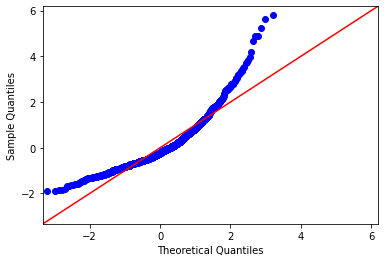

In [29]:
# Is the target normally distributed?
import statsmodels.api as sm
import matplotlib.pyplot as plt

norm_px = (house['SalePrice'] - house['SalePrice'].mean()) / house['SalePrice'].std()
sm.qqplot(norm_px, line ='45')
plt.show()
# No!

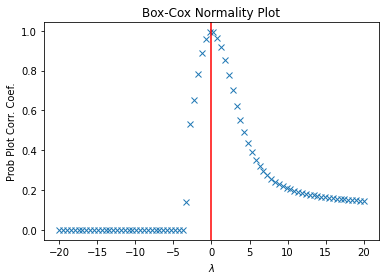

lambda = -0.04


In [30]:
from scipy import stats
# shift norm_px to the right to avoid negative values
norm_px_shft = (norm_px - norm_px.min() + 0.01)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
prob = stats.boxcox_normplot(house['SalePrice'], -20, 20, plot=ax3)

_, maxlog = stats.boxcox(house['SalePrice'])
ax3.axvline(maxlog, color='r')
plt.show()
print(f'lambda = {maxlog:.2f}')

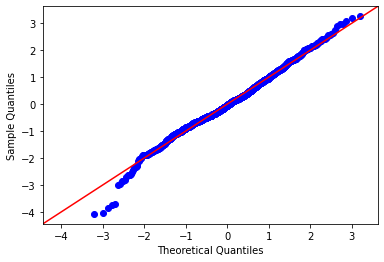

In [31]:
bc_prices = (house['SalePrice']**maxlog - 1) / maxlog
norm_bc_prices = (bc_prices - bc_prices.mean()) / bc_prices.std()
sm.qqplot(norm_bc_prices, line ='45')
plt.show()

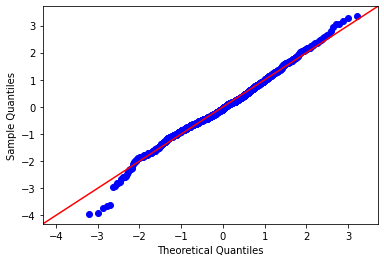

In [32]:
# Frankly, log works almost as well and it's fewer things to worry about
bc_prices = np.log(house['SalePrice'])
norm_bc_prices = (bc_prices - bc_prices.mean()) / bc_prices.std()
sm.qqplot(norm_bc_prices, line ='45')
plt.show()

In [33]:
# the Continuous Variables
contin = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal']

In [34]:
contin_plt = house[contin].drop(['LotFrontage', 'LotArea', 'MiscVal'], axis=1)
fig3 = px.box(pd.melt(contin_plt), x="variable", y="value")
fig3.update_layout(
    title='Continuous Variables',
    xaxis_title='',
    yaxis_title=''
)
# It's only worth using variables that have enough variation themselves
# GrLivArea is already an obvious first choice.  BsmtFinSF1 and TotalBsmtSF look like they add information,
# as does GarageArea
# 1stFlrSF etc. presumably are already covered by GrLivArea
# The variables to the right can either be converted to categorical (has pool / doesn't have pool)
# or ignored

In [35]:
# How correlated are these variables?
# First let's standardize to mean 0, std 1
house_s = house.copy()
for col in contin:
    house_s[col] = (house[col] - house[col].mean()) / house[col].std()
contin_corr = house_s[contin].T @ house_s[contin] / (nrows-1)

heat = go.Heatmap(z=contin_corr,
                  x=contin_corr.index,
                  y=contin_corr.index,
                  xgap=1, ygap=1,
                  colorscale='RdBu',
                  colorbar_thickness=20,
                  colorbar_ticklen=3,
                  #hovertext =hovertext,
                  #hoverinfo='text'
)
layout = go.Layout(title_text='Correlations of Contin Variables', title_x=0.5, 
                   width=600, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed'
                  )
   
fig4=go.Figure(data=[heat], layout=layout)        
fig4.show()

In [36]:
# the Discrete Variables
disc = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']

In [37]:
disc_cts_plt = house[disc].drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'], axis=1)
fig4 = px.box(pd.melt(disc_cts_plt), x="variable", y="value")
fig4.update_layout(
    title='Discrete Counting Variables',
    xaxis_title='',
    yaxis_title=''
)
# MoSold we covered already above
# GarageCars is an alternate to GarageArea above - pick 1
# However, GarageCars == 0 is a big problem so we need to make sure that's being picked up
# same applies I think to Bsmt stats here - either pick it up from the area stats or here, not both
# FullBath, HalfBath, BedroomAbvGr look interesting.  Suspect TotRmsAbvGrd is the sum of others + const.
# Kind of amazing spe houses had 0 FullBath?
# Kitchen adds no value, everybody has 1
# Fireplaces should be categorical yes/no

In [38]:
disc_yrs_plt = house[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']]
fig5 = px.box(pd.melt(disc_yrs_plt), x="variable", y="value")
fig5.update_layout(
    title='Discrete Year Variables',
    xaxis_title='',
    yaxis_title=''
)
# First two look sensible, GarageYrBlt probably correlates far too much with YearBuilt
# YrSold discussed already

In [39]:
# How correlated are these variables?
# First let's standardize to mean 0, std 1

for col in disc:
    house_s[col] = (house[col] - house[col].mean()) / house[col].std()
disc_corr = house_s[disc].T @ house_s[disc] / (nrows-1)

heat = go.Heatmap(z=disc_corr,
                  x=disc_corr.index,
                  y=disc_corr.index,
                  xgap=1, ygap=1,
                  colorscale='RdBu',
                  colorbar_thickness=20,
                  colorbar_ticklen=3,
                  #hovertext =hovertext,
                  #hoverinfo='text'
)
layout = go.Layout(title_text='Correlations of Discrete Variables', title_x=0.5, 
                   width=600, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed'
                  )
   
fig4=go.Figure(data=[heat], layout=layout)        
fig4.show()

In [41]:
# the Nominal Variables
nom = ['Id', 'MSSubClass', 'MSZoning', 'Street',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
       'SaleType', 'SaleCondition']

# let's ignore Id (which duplicates the dataframe index)
nom.remove('Id')

nom_summary = pd.DataFrame(index=nom, columns=['Type', 'Levels', 'MaxCount', 'MinCount', 'Missing'])

for col in nom:
    c = house[col].value_counts()
    nom_summary.loc[col, :] = [house[col].dtype, len(c), max(c), min(c), nrows - c.sum()]

# print(nom_summary.sort_values('MaxCount'))
# print('-'*54)
# Obviously ditch the first two (MiscFeature and Alley)
# It probably makes sense to throw out variables if > 50% of obs fall into one category

# This df will look at the variation in avg sale price using each variable as a groupby
nom_pxImpact = pd.DataFrame(index=nom, columns=['Levels', 'Min', 'Max', 'WVar', 'Missing'])
# I want to add linearity metrics, but that's tomorrow's task

# Let's weight the std of each level in the group by the number of observations in the level
def wgt_var(x, weights):
    return (np.dot(weights, (x - mu_sqft) ** 2)/weights.sum())
    
for col in nom:
    # should I look at absolute sale price or per sq ft?  TBD.  Going with per sq ft for now
    df = house.groupby(col)['SalePxSqFt'].agg(['mean', 'count']).sort_values('mean')
    # print(df)
    nom_pxImpact.loc[col, :] = [df.shape[0], df['mean'].min(), df['mean'].max(), 
                                wgt_var(df['mean'], df['count']/nrows), nrows - df['count'].sum()]

nom_pxImpact.sort_values('WVar', ascending=False)

,Levels,Min,Max,WVar,Missing
Neighborhood,25,84.7552,165.402,377.868,0
MSSubClass,15,82.5976,151.776,358.81,0
HouseStyle,8,74.4221,141.663,230.511,0
Foundation,6,84.5402,134.434,196.594,0
GarageType,7,87.0525,129.973,152.755,0
Exterior2nd,16,76.4192,174.699,150.317,0
Exterior1st,15,60.0962,161.33,148.487,0
SaleCondition,6,95.2015,155.623,136.851,0
MasVnrType,4,101.287,153.479,130.964,0
SaleType,9,101.924,163.795,126.054,0


In [43]:
# the Ordinal Variables
ords = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'OverallQual',
         'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
         'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
         'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
         'GarageQual', 'GarageCond', 'PavedDrive', 'Fence']

ord_summary = pd.DataFrame(index=ords, columns=['Type', 'Levels', 'MaxCount', 'MinCount', 'Missing'])

for col in ords:
    c = house[col].value_counts()
    ord_summary.loc[col, :] = [house[col].dtype, len(c), max(c), min(c), nrows - c.sum()]

ord_summary.sort_values('MaxCount')
# So let's ditch the first three

ord_pxImpact = pd.DataFrame(index=ords, columns=['Levels', 'Min', 'Max', 'WVar', 'Missing'])

for col in ords:
    df = house.groupby(col)['SalePxSqFt'].agg(['mean', 'count']).sort_values('mean')
    # print(df)
    ord_pxImpact.loc[col, :] = [df.shape[0], df['mean'].min(), df['mean'].max(), 
                                wgt_var(df['mean'], df['count']/nrows), nrows - df['count'].sum()]

ord_pxImpact.sort_values('WVar', ascending=False)

,Levels,Min,Max,WVar,Missing
BsmtQual,5,85.8403,164.426,296.3,0
OverallQual,10,79.8954,178.694,277.993,0
ExterQual,4,82.7537,176.121,247.688,0
KitchenQual,4,90.1988,162.54,239.854,0
BsmtFinType1,7,85.8403,142.562,234.908,0
BsmtExposure,5,86.4337,149.1,185.698,0
GarageFinish,4,93.8643,136.512,177.35,0
HeatingQC,5,97.4797,131.847,135.408,0
OverallCond,9,67.4779,127.684,121.467,0
BsmtCond,5,64.8439,132.587,84.1131,0


In [44]:
# How does sale price correlate with sq ft and does adding a quadratic term help?
x = house['GrLivArea'].values.reshape(-1, 1)
x_2 = x ** 2
#x_3 = x ** 3
#x_4 = x ** 4
X = np.concatenate([x, x_2], axis=1)
lin.fit(X, house['SalePrice'])
Y = lin.predict(X)
fig6 = go.Figure()
fig6.add_trace(go.Scatter(x=house['GrLivArea'], y=house['SalePrice'], name='SalePx', mode='markers', opacity=0.75))
fig6.add_trace(go.Scatter(x=house['GrLivArea'], y=Y, name='Fit', mode='markers'))
fig6.update_layout(
    title='Sale Price vs. Sq Ft above Grade',
    xaxis_title='Sq Ft',
    yaxis_title='Sale Price'
)
# The quadratic term didn't help